# Определение перспективного тарифа для телеком компании

# Описание проекта

## Основная задача проекта понять, какой тариф выгоднее для компании

Компания «Мегалайн», федеральный оператор сотовой связи, предлагает клиентам два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.
Описание тарифов
Тариф «Смарт»
1.	Ежемесячная плата: 550 рублей
2.	Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
•	минута разговора: 3 рубля
•	сообщение: 3 рубля
•	1 Гб интернет-трафика: 200 рублей
Тариф «Ультра»
1.	Ежемесячная плата: 1950 рублей
2.	Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
•	минута разговора: 1 рубль
•	сообщение: 1 рубль
•	1 Гб интернет-трафика: 150 рублей

«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

## Ознакомление с данными <a name="1"></a>

In [1]:
# импортируем основные библиотеки для работы
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np

In [2]:
# добавим все данные
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

### Начнем по порядку: рассмотрим подробнее таблицу "calls"

In [3]:
calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


Имеются нулевые значения в колонке "длительность звонка". Посмотрим много ли таких значений.

Количество значений с длительностью звонка, равной 0: 39613


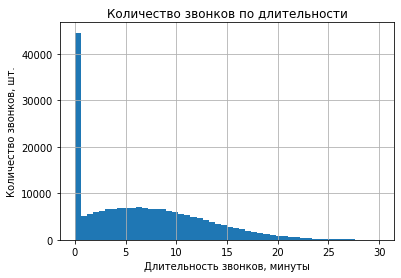

In [4]:
print('Количество значений с длительностью звонка, равной 0:', calls.query('duration == 0')['duration'].count())
plt.title('Количество звонков по длительности')
plt.xlabel('Длительность звонков, минуты')
plt.ylabel('Количество звонков, шт.')
calls['duration'].hist(bins=50, range=(0,30));

Почти 40 тысяч значений. Скорее всего нули это непринятые звонки, пропущенные вызовы. Они никак не влияют на сумму прибыли.
Поэтому просто удалим их.

Количество значений с длительностью звонка, равной 0: 0


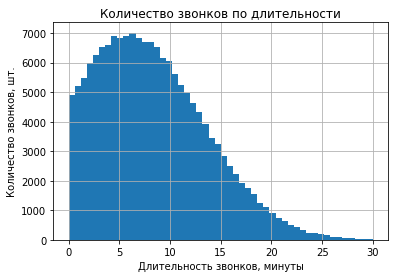

In [5]:
calls = calls[calls['duration'] != 0].copy()
print('Количество значений с длительностью звонка, равной 0:', calls.query('duration == 0')['duration'].count())
plt.title('Количество звонков по длительности')
plt.xlabel('Длительность звонков, минуты')
plt.ylabel('Количество звонков, шт.')
calls['duration'].hist(bins=50, range=(0,30));

График стал похож на правду после удаления ненужных нам значений.

In [6]:
calls['duration'].describe()

count    162994.000000
mean          8.397794
std           5.353022
min           0.010000
25%           4.170000
50%           7.740000
75%          11.850000
max          38.000000
Name: duration, dtype: float64

Среднее время разговора 8,4 минуты, а максимальное 34 минуты. Не так и много, если учитывать, что некоторые люди говорят по часу и больше.

Так как Мегалайн всегда округляет вверх значения минут, то округлим значения времени разговора и переведем в целые числа.

In [7]:
calls['duration'] = calls['duration'].apply(np.ceil).astype('int')
calls

,id,call_date,duration,user_id
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000
7,1000_7,2018-08-22,19,1000
8,1000_8,2018-09-15,19,1000
...,...,...,...,...
202602,1499_215,2018-12-26,1,1499
202603,1499_216,2018-10-18,19,1499
202604,1499_217,2018-11-10,11,1499
202605,1499_218,2018-10-06,5,1499


In [8]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 2 to 202606
Data columns (total 4 columns):
id           162994 non-null object
call_date    162994 non-null object
duration     162994 non-null int64
user_id      162994 non-null int64
dtypes: int64(2), object(2)
memory usage: 6.2+ MB


Дату стоит перевести в формат "Дата"

In [9]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 2 to 202606
Data columns (total 4 columns):
id           162994 non-null object
call_date    162994 non-null datetime64[ns]
duration     162994 non-null int64
user_id      162994 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB


In [10]:
calls.isna().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

Пропущенных значений нет

### Далее рассмотрим таблицу "internet"

In [11]:
internet

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


Похоже столбец "unnamed" полностью копирует индекс. Проверим, и если это так, удалим этот столбец.

In [12]:
ind = internet.index.tolist()
print('Разница между индексом и столбцом "unnamed"', (ind - internet['Unnamed: 0']).abs().sum())

Разница между индексом и столбцом "unnamed" 0


Удалим этот столбец.

In [13]:
del internet['Unnamed: 0']
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


Дату сессии переведем в формат "Дата".

In [14]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


Проверим много ли строк с 0 использованных мегабайт.

Количество значений с использованными мегабайтами, равными 0: 19598


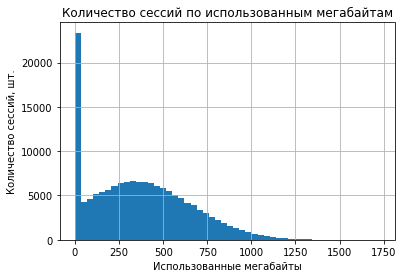

In [15]:
print('Количество значений с использованными мегабайтами, равными 0:', internet.query('mb_used == 0')['mb_used'].count())
plt.title('Количество сессий по использованным мегабайтам')
plt.xlabel('Использованные мегабайты')
plt.ylabel('Количество сессий, шт.')
internet['mb_used'].hist(bins=50);

19,5 тысяч нулевых значений. Странно, сессия была зафиксирована, но ни одного мегабайта потрачено не было. Было бы неплохо отправить для выборочной проверки нулевые сессии в специальный отдел. Удалим эти значения, так же как мы удалили и нулевые звонки.

Количество значений с использованными мегабайтами, равными 0: 0


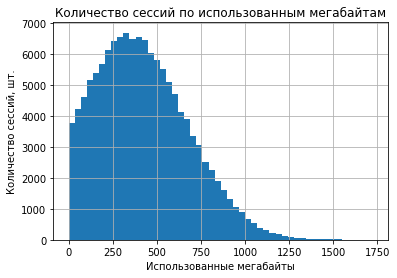

In [16]:
internet = internet[internet['mb_used'] != 0].copy()
print('Количество значений с использованными мегабайтами, равными 0:', internet.query('mb_used == 0')['mb_used'].count())
plt.title('Количество сессий по использованным мегабайтам')
plt.xlabel('Использованные мегабайты')
plt.ylabel('Количество сессий, шт.')
internet['mb_used'].hist(bins=50);

Исходя из политики компании, мегабайты следует округлить вверх и изменить тип столбца на "целый".

In [17]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil).astype('int')
internet

,id,mb_used,session_date,user_id
0,1000_0,113,2018-11-25,1000
1,1000_1,1053,2018-09-07,1000
2,1000_2,1198,2018-06-25,1000
3,1000_3,551,2018-08-22,1000
4,1000_4,303,2018-09-24,1000
...,...,...,...,...
149390,1499_151,753,2018-10-11,1499
149391,1499_152,319,2018-10-03,1499
149392,1499_153,491,2018-12-14,1499
149394,1499_155,1247,2018-11-26,1499


In [18]:
internet.isna().sum()

id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

Пропущенных значений нет.

### Проанализируем данные в таблице "messages".

In [19]:
display(messages)
messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Переведем дату сообщений в формат "Дата"

In [20]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [21]:
messages.isna().sum()

id              0
message_date    0
user_id         0
dtype: int64

Пропущенных значений нет

### Посмотрим на таблицу с тарифами

In [22]:
display(tariffs)
tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Просто справочная таблица с информацией о тарифах.

### Рассмотрим таблицу "users"

In [23]:
display(users)
users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


38 клиентов покинули оператора. Переведем даты в формат "Дата".

In [24]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [25]:
users['age'].describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

В столбце "Возраст" никаких отклонений.

## Подготовка данных <a name="2"></a>

Посчитаем для каждого пользователя:
•	количество сделанных звонков и израсходованных минут разговора по месяцам;
•	количество отправленных сообщений по месяцам;
•	объем израсходованного интернет-трафика по месяцам;
•	помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

### Количество сделанных звонков и израсходованных минут разговора по месяцам

In [26]:
# добавим столбец "month"
calls['month'] = calls['call_date'].dt.month
calls.head()

,id,call_date,duration,user_id,month
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
7,1000_7,2018-08-22,19,1000,8
8,1000_8,2018-09-15,19,1000,9


In [27]:
calls_by_user_month = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum']).copy()\
                           .reset_index()
calls_by_user_month.columns = calls_by_user_month.columns.droplevel(1)
calls_by_user_month = calls_by_user_month.rename(columns={"count": "count_duration", "sum": "sum_duration"})
print('Количество сделанных звонков и израсходованных минут разговора по месяцам:')
display(calls_by_user_month)
print('Количество звонков итого:', calls_by_user_month['count_duration'].sum())
print('Количество минут звонков итого:', calls_by_user_month['sum_duration'].sum())

Количество сделанных звонков и израсходованных минут разговора по месяцам:


,user_id,month,count_duration,sum_duration
0,1000,5,17,159
1,1000,6,28,172
2,1000,7,41,340
3,1000,8,42,408
4,1000,9,46,466
...,...,...,...,...
3163,1498,10,30,247
3164,1499,9,8,70
3165,1499,10,44,449
3166,1499,11,62,612


Количество звонков итого: 162994
Количество минут звонков итого: 1450301


### Количество отправленных сообщений по месяцам

In [28]:
# добавим столбец "month"
messages['month'] = messages['message_date'].dt.month
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [29]:
messages_by_user_month = messages.pivot_table(index=['user_id', 'month'], values='message_date', aggfunc='count').copy()\
                                 .rename(columns={"message_date": "number_of_messages"}).reset_index()
print('Количество отправленных сообщений по месяцам:')
display(messages_by_user_month)
print('Количество сообщений итого:', messages_by_user_month['number_of_messages'].sum())

Количество отправленных сообщений по месяцам:


,user_id,month,number_of_messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


Количество сообщений итого: 123036


### Объем израсходованного интернет-трафика по месяцам

In [30]:
# добавим столбец "month"
internet['month'] = internet['session_date'].dt.month
internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,113,2018-11-25,1000,11
1,1000_1,1053,2018-09-07,1000,9
2,1000_2,1198,2018-06-25,1000,6
3,1000_3,551,2018-08-22,1000,8
4,1000_4,303,2018-09-24,1000,9


In [31]:
internet_by_user_month = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum').copy()\
                         .reset_index()
print('Объем израсходованного интернет-трафика по месяцам:')
display(internet_by_user_month)
print('Количество мегабайт итого:', internet_by_user_month['mb_used'].sum())

Объем израсходованного интернет-трафика по месяцам:


,user_id,month,mb_used
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581
...,...,...,...
3196,1498,10,20604
3197,1499,9,1848
3198,1499,10,17809
3199,1499,11,17984


Количество мегабайт итого: 55369459


### Помесячная выручка с каждого пользователя

Для этого объединим три верхних таблицы и добавим к ним данные о тарифах для подсчета.

In [32]:
# используем "outer", чтобы не потерять строки с людьми, которые звонили, но не делали звонков и наоборот
profit = calls_by_user_month.merge(messages_by_user_month, on=['user_id', 'month'], how='outer')
profit = profit.merge(internet_by_user_month, on=['user_id', 'month'], how='outer')
profit = profit.merge(users, on='user_id', how='left')
tariffs = tariffs.rename(columns={"tariff_name": "tariff"}) # переименуем название столбца, чтобы по нему склеить
profit = profit.merge(tariffs, on='tariff', how='left')

Проверим на пропущенные значения.

In [33]:
print(profit.isna().sum())

user_id                     0
month                       0
count_duration             46
sum_duration               46
number_of_messages        497
mb_used                    13
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64


Пропущенные значения заменим на ноль, так как это случаи, когда человек пользовался не всеми включенными услугами. Например, только звонил и писал сообщения, но интернетом не пользовался. Если мы уберем NaN из даты прекращения пользования тарифом, это будет для нас не критично.

In [34]:
profit = profit.fillna(0) # заполним Nan нулями для дальнейших подсчетов
profit.head()

,user_id,month,count_duration,sum_duration,number_of_messages,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,17.0,159.0,22.0,2256.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,28.0,172.0,60.0,23257.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,41.0,340.0,75.0,14016.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,42.0,408.0,81.0,14070.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,46.0,466.0,57.0,14581.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


Проверим сходятся ли суммы звонков, сообщений и мегабайт

In [35]:
print('Количество звонков итого:', profit['count_duration'].sum())
print('Количество минут звонков итого:', profit['sum_duration'].sum())
print('Количество сообщений итого:', profit['number_of_messages'].sum())
print('Количество использованных мегабайт итого:', profit['mb_used'].sum())

Количество звонков итого: 162994.0
Количество минут звонков итого: 1450301.0
Количество сообщений итого: 123036.0
Количество использованных мегабайт итого: 55369459.0


Всё верно.

Посчитаем прибыль отдельно по звонкам, сообщениям и интернету, сверх тарифа. 
В описании тарифов дана цена за гигабайт, значит такие условия тарифа. Переведем мегабайты в гигабайты и округлим вверх.

In [36]:
profit['calls_profit'] = (profit['sum_duration'] - profit['minutes_included'])*profit['rub_per_minute']
profit['message_profit'] = (profit['number_of_messages'] - profit['messages_included'])*profit['rub_per_message']
profit['internet_profit'] = np.ceil((profit['mb_used'] - profit['mb_per_month_included'])/1024)*profit['rub_per_gb']
display(profit)

,user_id,month,count_duration,sum_duration,number_of_messages,mb_used,age,churn_date,city,first_name,...,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_profit,message_profit,internet_profit
0,1000,5,17.0,159.0,22.0,2256.0,52,0,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,-2841.0,-978.0,-4050.0
1,1000,6,28.0,172.0,60.0,23257.0,52,0,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,-2828.0,-940.0,-1050.0
2,1000,7,41.0,340.0,75.0,14016.0,52,0,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,-2660.0,-925.0,-2400.0
3,1000,8,42.0,408.0,81.0,14070.0,52,0,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,-2592.0,-919.0,-2400.0
4,1000,9,46.0,466.0,57.0,14581.0,52,0,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,-2534.0,-943.0,-2250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,10,0.0,0.0,21.0,19588.0,35,0,Санкт-Петербург,Павел,...,50,15360,500,550,200,3,3,-1500.0,-87.0,1000.0
3210,1489,11,0.0,0.0,20.0,17516.0,35,0,Санкт-Петербург,Павел,...,50,15360,500,550,200,3,3,-1500.0,-90.0,600.0
3211,1489,12,0.0,0.0,35.0,17341.0,35,0,Санкт-Петербург,Павел,...,50,15360,500,550,200,3,3,-1500.0,-45.0,400.0
3212,1240,2,0.0,0.0,0.0,961.0,30,0,Воронеж,Зинаида,...,1000,30720,3000,1950,150,1,1,-3000.0,-1000.0,-4350.0


Далее удалим отрицательные значения. Это случаи, когда абонент не израсходовал включенные в тариф услуги.
Действуем проще.

In [37]:
profit.loc[profit['calls_profit'] < 0, 'calls_profit'] = 0
profit.loc[profit['message_profit'] < 0, 'message_profit'] = 0
profit.loc[profit['internet_profit'] < 0, 'internet_profit'] = 0
display(profit)

,user_id,month,count_duration,sum_duration,number_of_messages,mb_used,age,churn_date,city,first_name,...,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_profit,message_profit,internet_profit
0,1000,5,17.0,159.0,22.0,2256.0,52,0,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
1,1000,6,28.0,172.0,60.0,23257.0,52,0,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
2,1000,7,41.0,340.0,75.0,14016.0,52,0,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
3,1000,8,42.0,408.0,81.0,14070.0,52,0,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
4,1000,9,46.0,466.0,57.0,14581.0,52,0,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,10,0.0,0.0,21.0,19588.0,35,0,Санкт-Петербург,Павел,...,50,15360,500,550,200,3,3,0.0,0.0,1000.0
3210,1489,11,0.0,0.0,20.0,17516.0,35,0,Санкт-Петербург,Павел,...,50,15360,500,550,200,3,3,0.0,0.0,600.0
3211,1489,12,0.0,0.0,35.0,17341.0,35,0,Санкт-Петербург,Павел,...,50,15360,500,550,200,3,3,0.0,0.0,400.0
3212,1240,2,0.0,0.0,0.0,961.0,30,0,Воронеж,Зинаида,...,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0


Найдем общую прибыль по каждому абоненту, прибавив абонентскую плату к прибыли по услугам.

In [38]:
profit['profit_over_tariff'] = profit['calls_profit'] + profit['message_profit'] + profit['internet_profit']
profit['total_profit'] = profit['rub_monthly_fee'] + profit['profit_over_tariff']
display(profit)
print('Общая прибыль по всем тарифам:', profit['total_profit'].sum())

,user_id,month,count_duration,sum_duration,number_of_messages,mb_used,age,churn_date,city,first_name,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_profit,message_profit,internet_profit,profit_over_tariff,total_profit
0,1000,5,17.0,159.0,22.0,2256.0,52,0,Краснодар,Рафаил,...,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
1,1000,6,28.0,172.0,60.0,23257.0,52,0,Краснодар,Рафаил,...,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
2,1000,7,41.0,340.0,75.0,14016.0,52,0,Краснодар,Рафаил,...,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
3,1000,8,42.0,408.0,81.0,14070.0,52,0,Краснодар,Рафаил,...,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
4,1000,9,46.0,466.0,57.0,14581.0,52,0,Краснодар,Рафаил,...,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,10,0.0,0.0,21.0,19588.0,35,0,Санкт-Петербург,Павел,...,500,550,200,3,3,0.0,0.0,1000.0,1000.0,1550.0
3210,1489,11,0.0,0.0,20.0,17516.0,35,0,Санкт-Петербург,Павел,...,500,550,200,3,3,0.0,0.0,600.0,600.0,1150.0
3211,1489,12,0.0,0.0,35.0,17341.0,35,0,Санкт-Петербург,Павел,...,500,550,200,3,3,0.0,0.0,400.0,400.0,950.0
3212,1240,2,0.0,0.0,0.0,961.0,30,0,Воронеж,Зинаида,...,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0


Общая прибыль по всем тарифам: 4925751.0


## Анализ данных <a name="3"></a>

Опишем поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы.

Для начала узнаем какой тариф у данных 500 пользователей наиболее популярный.

In [39]:
users['tariff'].value_counts(normalize=True)

smart    0.702
ultra    0.298
Name: tariff, dtype: float64

Большинство используют тариф подешевле (70% абонентов). Узнаем, возможно, они больше переплачивают.
Интересно пользователи какого тарифа платят больше за использование услуг сверх пакета тарифа.

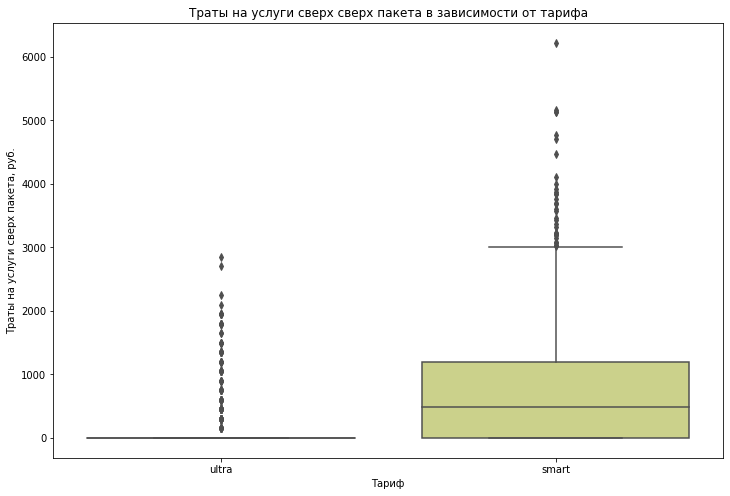

In [40]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="tariff", y="profit_over_tariff", data=profit, palette='rainbow');
plt.title('Траты на услуги сверх сверх пакета в зависимости от тарифа')
plt.xlabel('Тариф')
plt.ylabel('Траты на услуги сверх пакета, руб.')
plt.show()

Да, явно у абонентов тарифа смарт переплат больше. А многие тратят более 3 тысяч рублей на дополнительные услуги сверх пакета.
Рассмотрим их итоговые траты.

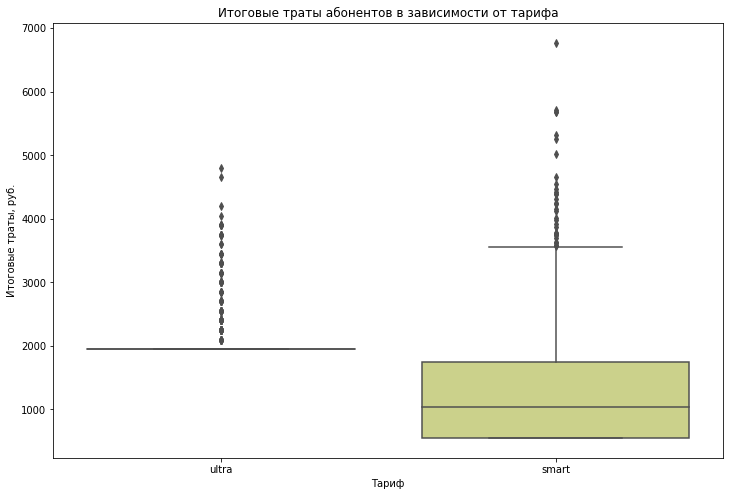

In [41]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="tariff", y="total_profit", data=profit, palette='rainbow');
plt.title('Итоговые траты абонентов в зависимости от тарифа')
plt.xlabel('Тариф')
plt.ylabel('Итоговые траты, руб.')
plt.show()

Судя по медиане большинство пользователей тарифа Смарт укладывается в тысячу рублей. Остальные же тратят на связь от 1000 до 1800 рублей, за исключением категории людей, тратящих более 3,5 тысяч рублей.
А большинство абонентов тарифа Ультра укладываются в лимит пакета по тарифу.

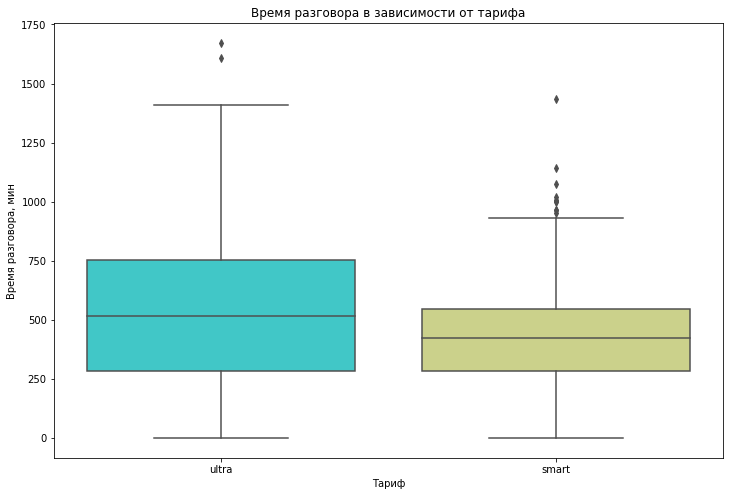

In [42]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="tariff", y="sum_duration", data=profit, palette='rainbow');
plt.title('Время разговора в зависимости от тарифа')
plt.xlabel('Тариф')
plt.ylabel('Время разговора, мин')
plt.show()

Абоненты тарифа Ультра разговаривают больше, чем люди на тарифе Смарт. Но на тарифе смарт имеются сверхразговорчивые люди, которые тратят больше минут, чем на тарифе Ультра. Им бы не мешало сменить тариф.

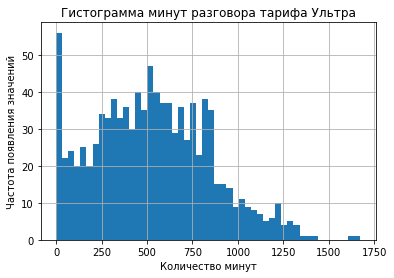

In [43]:
profit[profit['tariff'] == 'ultra']['sum_duration'].hist(bins=50);
plt.title('Гистограмма минут разговора тарифа Ультра')
plt.xlabel('Количество минут')
plt.ylabel('Частота появления значений')
plt.show()

In [44]:
profit[profit['tariff'] == 'ultra']['sum_duration'].describe()

count     985.000000
mean      526.623350
std       317.606098
min         0.000000
25%       284.000000
50%       518.000000
75%       752.000000
max      1673.000000
Name: sum_duration, dtype: float64

Никто в тарифе Ультра не тратит количество минут, заложенных в тарифе. Некоторые люди не пользуются звонками или совсем мало разговаривают. Посмотрим, что с сообщениями.

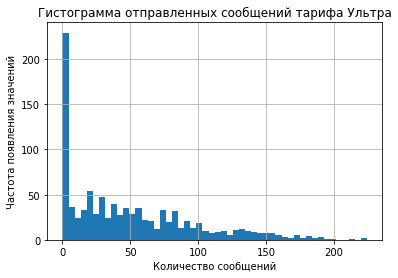

In [45]:
profit[profit['tariff'] == 'ultra']['number_of_messages'].hist(bins=50);
plt.title('Гистограмма отправленных сообщений тарифа Ультра')
plt.xlabel('Количество сообщений')
plt.ylabel('Частота появления значений')
plt.show()

In [46]:
profit[profit['tariff'] == 'ultra']['number_of_messages'].describe()

count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: number_of_messages, dtype: float64

Большое количество не пользуются сообщениями вообще. Зачем, когда есть интернет! 
Но всё-таки есть люди которые в среднем отправляют по сто сообщений и больше. Но в лимит 1000 сообщений укладываются все.
Рассмотрим интернет.

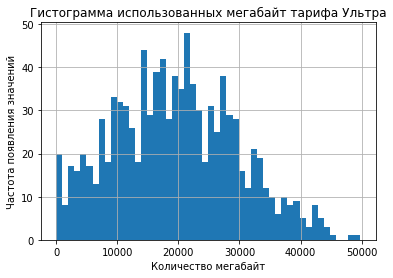

In [47]:
profit[profit['tariff'] == 'ultra']['mb_used'].hist(bins=50);
plt.title('Гистограмма использованных мегабайт тарифа Ультра')
plt.xlabel('Количество мегабайт')
plt.ylabel('Частота появления значений')
plt.show()

In [48]:
profit[profit['tariff'] == 'ultra']['mb_used'].describe()

count      985.000000
mean     19486.901523
std      10096.317202
min          0.000000
25%      11785.000000
50%      19324.000000
75%      26863.000000
max      49789.000000
Name: mb_used, dtype: float64

А за интернет приходится доплачивать. В основном в лимит в 30 720 мегабайт большинство укладывается. Но большое количество людей используют интернет сверх тарифа.
Рассмотрим тариф Смарт.

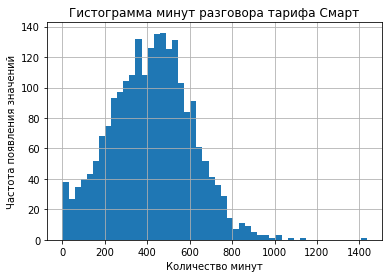

In [49]:
profit[profit['tariff'] == 'smart']['sum_duration'].hist(bins=50);
plt.title('Гистограмма минут разговора тарифа Смарт')
plt.xlabel('Количество минут')
plt.ylabel('Частота появления значений')
plt.show()

In [50]:
profit[profit['tariff'] == 'smart']['sum_duration'].describe()

count    2229.000000
mean      417.934948
std       190.313730
min         0.000000
25%       282.000000
50%       422.000000
75%       545.000000
max      1435.000000
Name: sum_duration, dtype: float64

Больше 25% не укладываются в 500 минутный лимит пакета тарифа.

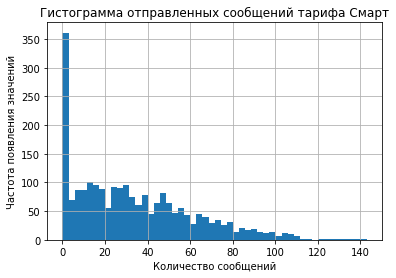

In [51]:
profit[profit['tariff'] == 'smart']['number_of_messages'].hist(bins=50);
plt.title('Гистограмма отправленных сообщений тарифа Смарт')
plt.xlabel('Количество сообщений')
plt.ylabel('Частота появления значений')
plt.show()

In [52]:
profit[profit['tariff'] == 'smart']['number_of_messages'].describe()

count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: number_of_messages, dtype: float64

25% не укладываются в лимит 50 сообщений.

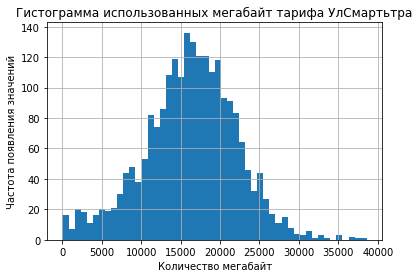

In [53]:
profit[profit['tariff'] == 'smart']['mb_used'].hist(bins=50);
plt.title('Гистограмма использованных мегабайт тарифа УлСмартьтра')
plt.xlabel('Количество мегабайт')
plt.ylabel('Частота появления значений')
plt.show()

In [54]:
profit[profit['tariff'] == 'smart']['mb_used'].describe()

count     2229.000000
mean     16229.188425
std       5877.576978
min          0.000000
25%      12658.000000
50%      16531.000000
75%      20068.000000
max      38610.000000
Name: mb_used, dtype: float64

И больше полоины пользователей тарифа смарт не укладываются в лимит интернета в 15 360 МБ.
Сведем в общую таблицу среднее, медиану, дисперсию, стандартное отклонение и общую прибыль по каждому тарифу по колонке общая прибыль.

In [55]:
display(profit.pivot_table(index='tariff', values='total_profit', aggfunc=['mean', 'median', 'var', 'std', 'sum']))

,mean,median,var,std,sum
,total_profit,total_profit,total_profit,total_profit,total_profit
tariff,,,,,
smart,1294.63930,1038.0,673931.321363,820.933202,2885751.0
ultra,2071.06599,1950.0,143491.240560,378.802377,2040000.0


Как уже было сказано выше, пользователи тарифа Смарт в большем количестве превышают услуги пакета, соответственно больше переплачивают. Удачным решением было бы создание для таких абонентов промежуточного тарифа, а то слишком велика разница между этими двумя тарифами, они не покрывают все потребности возможных клиентов. А пользователи тарифа Ультра редко превышают свои лимиты, только единичные случаи по части использованных мегабайт. Но от абонентов тарифа Смарт прибыль на 800 тыся рублей выше, но и абонентов больше (70% против 30%).

## Проверка гипотез <a name="4"></a>

Нам предстоит проверить две гипотезы:
•	средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
•	средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Начнем с первой. Н0 будет звучать так: средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается.
Н1 будет звучать наоборот: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
Из-за различия дисперсий этих выборок возьмём параметр "equal_var=False".

Проверим с помощью теста Левена на равенство дисперсий двух выборок: Н0 - дисперсии не различаются. Н1 - дисперсии различаются.

In [56]:
leven = st.levene(profit.loc[profit['tariff'] == 'ultra']['total_profit'], \
                  profit.loc[profit['tariff'] == 'smart']['total_profit'], center='mean')
print('p-значение:', leven.pvalue)
if (leven.pvalue < 0.05):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 7.106948063979338e-133
Отвергаем нулевую гипотезу


Тест показал, что дисперсии различны. Значит при сравнении средних этих выборок Т-тестом используем параметр equal_var=False.

In [57]:
results = st.ttest_ind(profit.loc[profit['tariff'] == 'ultra']['total_profit'],\
                       profit.loc[profit['tariff'] == 'smart']['total_profit'], equal_var=False)
print('p-значение:', results.pvalue)

if (results.pvalue < 0.05):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 2.7240946993530846e-246
Отвергаем нулевую гипотезу


Различия не случайны, очень низкая вероятность случайного получения этих данных в датасетах.

Вторая гипотеза звучит так: Н0 - средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов. Н1 - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
Проверим, нет ли Москвы, написанной с ошибкой.

In [58]:
display(profit['city'].unique())

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Курган', 'Барнаул', 'Красноярск', 'Архангельск', 'Липецк',
       'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Волжский', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

Нет, Москва одна.

Так же проверим с помощью теста Левена на равенство дисперсий двух выборок: Н0 - дисперсии не различаются. Н1 - дисперсии различаются.

In [59]:
leven = st.levene(profit.loc[profit['city'] == 'Москва']['total_profit'],\
                  profit.loc[profit['tariff'] != 'Москва']['total_profit'], center='mean')
print('p-значение:', leven.pvalue)
if (leven.pvalue < 0.05):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.0843168672583135
Не получилось отвергнуть нулевую гипотезу


Тест показал, что дисперсии различны. Значит при сравнении средних этих выборок Т-тестом используем параметр equal_var=False.

In [60]:
results = st.ttest_ind(profit.loc[profit['city'] == 'Москва']['total_profit'],\
                       profit.loc[profit['tariff'] != 'Москва']['total_profit'], equal_var=False)
print('p-значение:', results.pvalue)

if (results.pvalue < 0.05):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.5873583696357267
Не получилось отвергнуть нулевую гипотезу


59 процентов очень высокая вероятность. Это может быть просто случайность.

## Общий вывод <a name="5"></a>

Самый популярный тариф это "Смарт" - им пользуются 70% из 500 абонентов выборки. Он так же приносит и больше выручки на 800 тысяч рублей(отношение выручки Смарт / Ультра - 59% / 41%). Но пользователи тарифа Смарт постоянно переплачивают за услуги тарифа. Возможно Ультра для них слишком дорогой, а Смарта им мало, было бы неплохо создать средний тариф. 
При лояльном отношении компании к своим клиентам было бы здорово оповестить клиентов тарифа Смарт, которые платят за услуги более 2000 рублей, о существовании тарифа Ультра, возможно они бы тогда с радостью перешли на него, тем самым они бы платили абонентскую плату выше, чем раньше, это хорошо для компании. Иначе есть вероятность, что они могут уйти.